In [21]:
import pandas as pd

# Load the CSV files
slearner_data = pd.read_csv('../results/s_predictions.csv')
tlearner_data = pd.read_csv('../results/t_predictions.csv')
xlearner_data = pd.read_csv('../results/x_predictions.csv')
rlearner_data = pd.read_csv('../results/r_predictions.csv')


In [22]:
# Add a learner identifier column
slearner_data['Learner'] = 'S-Learner'
tlearner_data['Learner'] = 'T-Learner'
rlearner_data['Learner'] = 'R-Learner'
xlearner_data['Learner'] = 'X-Learner'

In [23]:
# Combine all data into one DataFrame
combined_data = pd.concat([slearner_data, tlearner_data, rlearner_data, xlearner_data], ignore_index=True)
combined_data.head()


,schoolid,GrowthMindsetIntervention,StudentAchievementScore,FutureSuccessExpectations,StudentRaceEthnicity,StudentGender,FirstGenCollegeStatus,SchoolUrbanicity,PreInterventionFixedMindset,SchoolAchievementLevel,SchoolMinorityComposition,PovertyConcentration,TotalStudentPopulation,CATE,Learner
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.242115,S-Learner
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.180260,S-Learner
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.242115,S-Learner
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.242115,S-Learner
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.223880,S-Learner


In [24]:
# List of features to calculate CATE for

features = [
    'schoolid', 'GrowthMindsetIntervention', 'FutureSuccessExpectations',
    'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity',
    'PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition',
    'PovertyConcentration', 'TotalStudentPopulation'
]
# Initialize a dictionary to hold CATE results
cate_results = {}
# Initialize a dictionary to hold actual prediction results

In [25]:
# Function to calculate CATE for a given feature
def calculate_cate(feature):
    grouped_data = combined_data.groupby(['Learner', feature]).agg({'CATE': 'mean'}).reset_index()
    grouped_data.columns = ['Learner', feature, 'CATE']
    return grouped_data

In [26]:
# Calculate CATE for each feature and store the results
for feature in features:
    cate_results[feature] = calculate_cate(feature)
  # Assuming the aggregation provides one row per feature

In [27]:
# Display a sample of the CATE results for one feature
cate_results['StudentGender'].head()

actual_scores = {feature: combined_data.groupby(feature)['StudentAchievementScore'].mean() for feature in features}
print(type(actual_scores[feature]))

<class 'pandas.core.series.Series'>


In [28]:
# Create a matrix to compare CATE predictions for all features and learners
comparison_matrix = pd.DataFrame(index=features, columns=['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner','StudentAchievementScore'])



In [29]:
# Fill the matrix with the average CATE values
for feature in features:
    for learner in ['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner']:
        learner_data = cate_results[feature]
        mean_cate = learner_data[learner_data['Learner'] == learner]['CATE'].mean()
        comparison_matrix.loc[feature, learner] = mean_cate
    # Get the average actual prediction for the feature
    comparison_matrix.loc[feature, 'StudentAchievementScore'] = actual_scores[feature].iloc[0]

# Display the comparison matrix
comparison_matrix


,S-Learner,T-Learner,R-Learner,X-Learner,StudentAchievementScore
schoolid,0.230647,0.278851,0.502452,0.240691,-0.385795
GrowthMindsetIntervention,0.244798,0.279892,0.46901,0.253454,-0.195639
FutureSuccessExpectations,0.243297,0.252234,0.666306,0.212314,-0.525624
StudentRaceEthnicity,0.240382,0.278262,0.440988,0.248819,-0.062681
StudentGender,0.243489,0.279347,0.483333,0.251988,0.003672
FirstGenCollegeStatus,0.246866,0.280338,0.448767,0.255865,0.012984
SchoolUrbanicity,0.240176,0.278914,0.501182,0.251655,0.027419
PreInterventionFixedMindset,0.230647,0.278851,0.502452,0.240691,0.506298
SchoolAchievementLevel,0.230647,0.278851,0.502452,0.240691,-0.080293
SchoolMinorityComposition,0.230647,0.278851,0.502452,0.240691,-0.341006


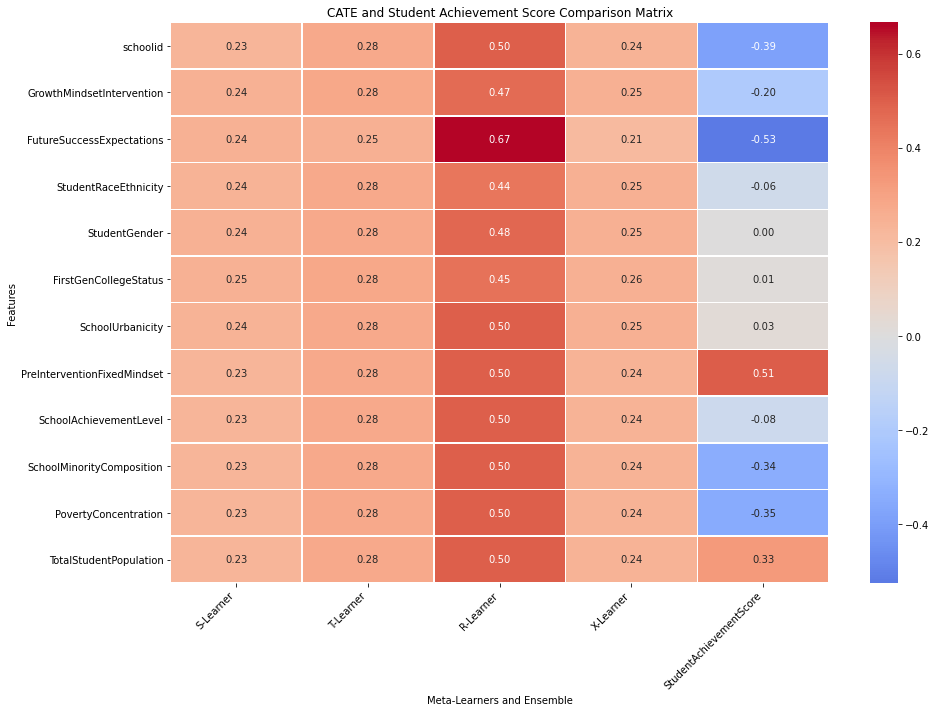

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

# Heatmap with diverging color palette for better differentiation
sns.heatmap(comparison_matrix.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE and Student Achievement Score Comparison Matrix')
plt.xlabel('Meta-Learners and Ensemble')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure for better clarity
plt.savefig("CATE_Comparison_Matrix.png", dpi=300)
plt.show()








The heatmap shows a comparison of the Causal Average Treatment Effect (CATE) across different meta-learners (S-Learner, T-Learner, R-Learner, X-Learner) for various features. The "StudentAchievementScore" column provides the actual observed effect on student achievement.

## Key Observations
### R-Learner:
The R-Learner consistently shows a higher CATE value compared to the other learners, especially for features like FutureSuccessExpectations, SchoolUrbanicity, PreInterventionFixedMindset, SchoolMinorityComposition, and PovertyConcentration, all reaching 0.50.
This suggests that R-Learner is particularly sensitive to these features, possibly indicating that it captures more nuanced treatment effects or that it might be overestimating the effects compared to other learners.

### X-Learner:
The X-Learner displays a CATE value of around 0.24-0.25 for most features, except FutureSuccessExpectations, which is slightly lower at 0.21. This suggests that the X-Learner provides a more conservative estimate of the treatment effect, potentially indicating robustness but also a possibility of underestimating the effect.

### S-Learner & T-Learner:
Both S-Learner and T-Learner exhibit similar CATE values around 0.23-0.28 for all features, suggesting that these models are either less sensitive to the features or consistently providing a more uniform estimation.

### Student Achievement Score:
The actual observed student achievement score varies significantly. For instance, features like FutureSuccessExpectations, SchoolMinorityComposition, and PovertyConcentration show a negative effect (-0.53, -0.34, and -0.35 respectively).
In contrast, PreInterventionFixedMindset has a strong positive impact (0.51), indicating that interventions targeting this feature may have the most significant positive effect on student outcomes.

## Deduction:
### Overestimation by R-Learner
The high CATE values from the R-Learner, particularly in comparison to the actual StudentAchievementScore, suggest potential overestimation of treatment effects.

### Conservative Estimates by X-Learner
The lower and more uniform CATE values from the X-Learner indicate it might be more conservative, which could lead to more robust but possibly underestimating predictions.

### Feature Sensitivity
Features like FutureSuccessExpectations, PreInterventionFixedMindset, and socio-economic factors (PovertyConcentration, SchoolMinorityComposition) are crucial as they show significant variations in CATE and actual achievement scores.


## Further Experimentation: Representation and Analysis



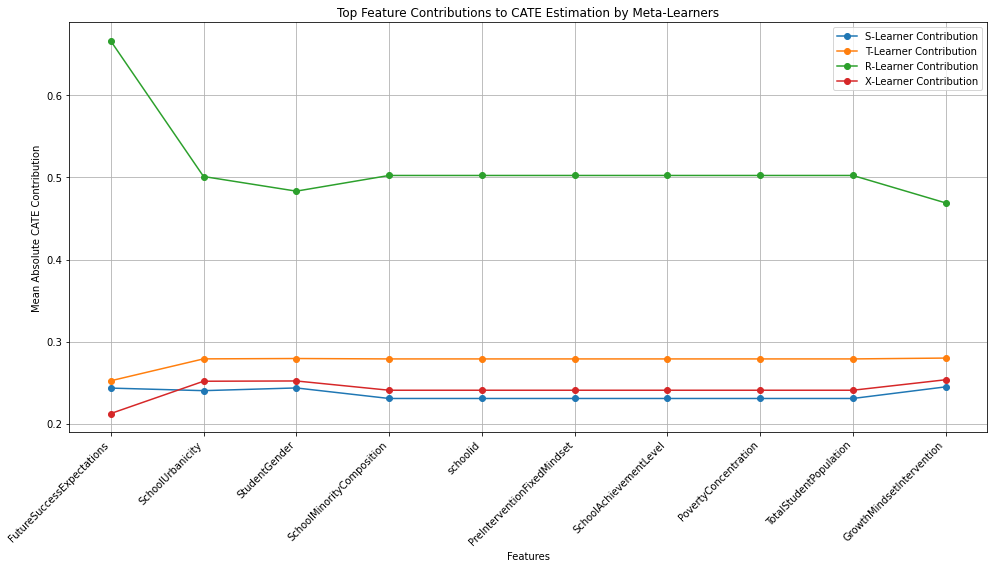